# HVNM Tutorial 02: Creep Compliance — NLSQ to NUTS

**Fit creep compliance J(t) with the Hybrid Vitrimer Nanocomposite Model**

Under a step stress $\sigma_0$, the HVNM creep compliance is:

$$J(t) = \frac{1}{G_P X(\phi)} + \frac{1}{G_E}\left(1 - e^{-2k_{BER}^{mat}t}\right) + \frac{1}{G_I X_I}\left(1 - e^{-2k_{BER}^{int}t}\right) + \frac{1}{G_D}\left(1 - e^{-k_d^D t}\right) + \frac{t}{\eta_E}$$

This multi-exponential retardation spectrum + viscous flow constrains:
**G_P, G_E, G_D, nu_0** (controls k_BER), and **k_d_D**.

## Dataset
Polystyrene at 190 C — creep compliance J(t)

## Estimated Runtime
- NLSQ: ~10 s | NUTS: ~1 min (FAST_MODE) / ~10 min (production)

In [1]:
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    configure_hvnm_for_fit,
    get_bayesian_config,
    get_fast_mode,
    get_nlsq_values,
    get_output_dir,
    load_ps_creep,
    plot_fit_comparison,
    plot_ppc,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
    setup_style,
)

setup_style()
print(f"JAX {jax.__version__}, FAST_MODE: {get_fast_mode()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX 0.8.3, FAST_MODE: True


## 2. Load Data and Apply QC

Protocol: creep
  Points: 149 / 150
  x range: [2.633, 3605]
  y range: [0.000104, 0.05367]
  material: Polystyrene at 190 C
  source: pyRheo demos
  units_x: s
  units_y: 1/Pa
  temperature_C: 190

Applied stress (assumed): 1.0 Pa
Note: Creep data is J(t) = gamma(t)/sigma_0


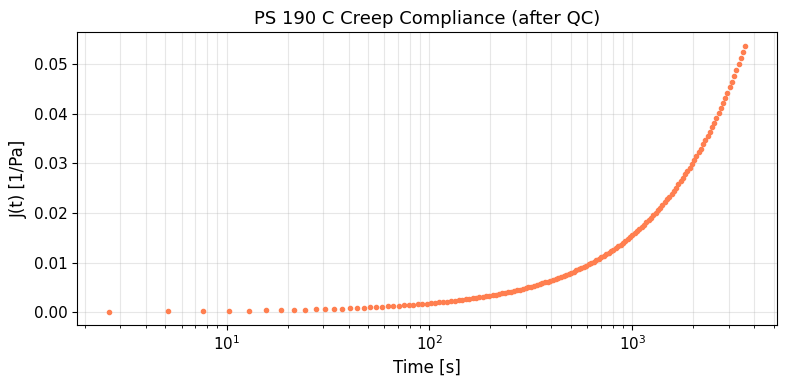

In [3]:
data = load_ps_creep(temperature=190, max_points=150)

# Early-time exclusion (inertial effects)
early_cut = 0.5  # seconds
data.mask = data.x >= early_cut

print(data.summary())
print(f"\nApplied stress (assumed): {data.protocol_kwargs['sigma_applied']} Pa")
print(f"Note: Creep data is J(t) = gamma(t)/sigma_0")

fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogx(data.x_masked, data.y_masked, 'o', ms=3, color='coral')
ax.set_xlabel(data.x_label)
ax.set_ylabel(data.y_label)
ax.set_title('PS 190 C Creep Compliance (after QC)')
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## 3. Configure HVNM and Fit (NLSQ)

In [4]:
model = HVNMLocal(include_dissociative=True)
fit_params = configure_hvnm_for_fit(
    model,
    protocol="creep",
    overrides={
        "G_P": 1e5,
        "G_E": 5e4,
        "G_D": 1e4,
        "nu_0": 1e8,
        "k_d_D": 0.1,
        "T": 463.15,  # 190 C in Kelvin
        "phi": 0.0,   # No nanoparticles for PS
    },
)
print(f"Fittable: {fit_params}")

t0 = time.time()
model.fit(
    data.x_masked,
    data.y_masked,
    test_mode="creep",
    sigma_applied=data.protocol_kwargs['sigma_applied'],
    max_iter=3000,
)
print(f"NLSQ: {time.time() - t0:.1f} s")

nlsq_vals = get_nlsq_values(model, fit_params)
for p, v in nlsq_vals.items():
    print(f"  {p} = {v:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fittable: ['G_P', 'G_E', 'G_D', 'nu_0', 'k_d_D']


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.655113s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=73.8351 | elapsed=1.655s | final_gradient_norm=3.3228e+04


NLSQ: 2.4 s
  G_P = 1e+05
  G_E = 5e+04
  G_D = 1e+04
  nu_0 = 1e+08
  k_d_D = 160.6


Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_02_creep_nlsq_fit.png


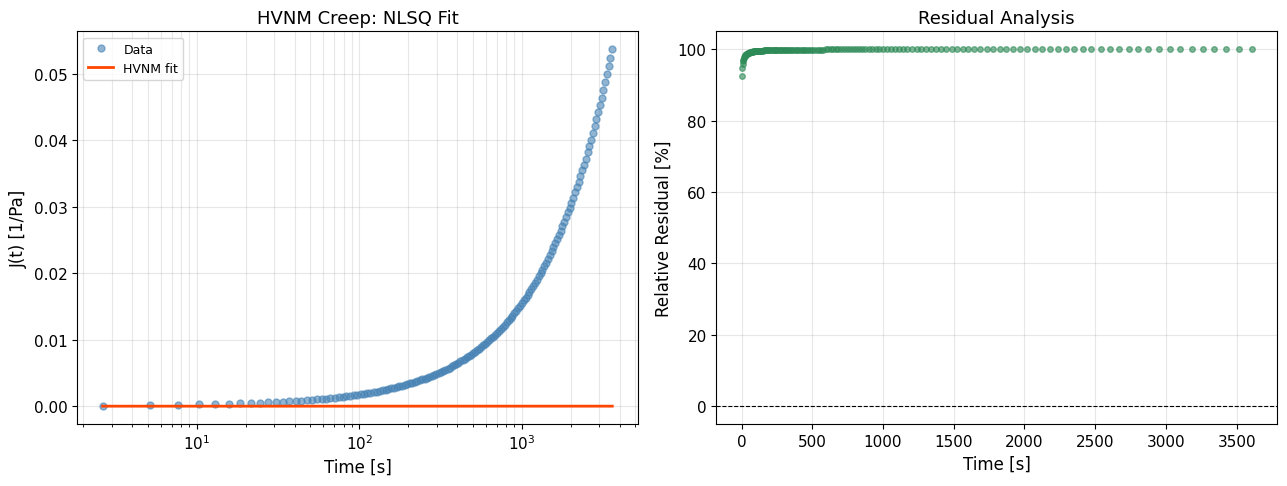

In [5]:
fig = plot_fit_comparison(data, model, title="HVNM Creep: NLSQ Fit")
save_figure(fig, "hvnm_02_creep_nlsq_fit.png")
plt.show()

## 4. Bayesian Inference (NUTS)

In [6]:
bayes_cfg = get_bayesian_config()
print(f"Config: {bayes_cfg}")

t0 = time.time()
result = model.fit_bayesian(
    data.x_masked,
    data.y_masked,
    test_mode="creep",
    sigma_applied=data.protocol_kwargs['sigma_applied'],
    **bayes_cfg,
)
print(f"NUTS: {time.time() - t0:.1f} s")

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:16,  1.32s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  21%|██▏       | 32/150 [00:01<00:03, 31.03it/s, 127 steps of size 1.06e-01. acc. prob=0.85]

sample:  70%|███████   | 105/150 [00:01<00:00, 116.67it/s, 15 steps of size 1.50e-01. acc. prob=0.97]

sample: 100%|██████████| 150/150 [00:01<00:00, 96.52it/s, 15 steps of size 1.50e-01. acc. prob=0.97] 

NUTS: 4.4 s


## 5. Diagnostics and PPC

In [7]:
print_convergence(result, fit_params)
print()
print_parameter_table(fit_params, nlsq_vals, result.posterior_samples)

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    0.9909       194
         G_E    0.9900       154
         G_D    0.9902       252
        nu_0    0.9979       378
       k_d_D    1.0132       196

Divergences: 0
Convergence: PASSED

Parameter Comparison
       Param          NLSQ    Bayes(med)                    95% CI
------------------------------------------------------------------
         G_P         1e+05     5.114e+08  [2.235e+07, 9.325e+08]
         G_E         5e+04     5.017e+08  [2.529e+07, 9.531e+08]
         G_D         1e+04     5.269e+07  [2.051e+06, 9.914e+07]
        nu_0         1e+08     6.181e+13  [3.416e+12, 9.65e+13]
       k_d_D         160.6     4.762e+05  [3.435e+04, 9.429e+05]


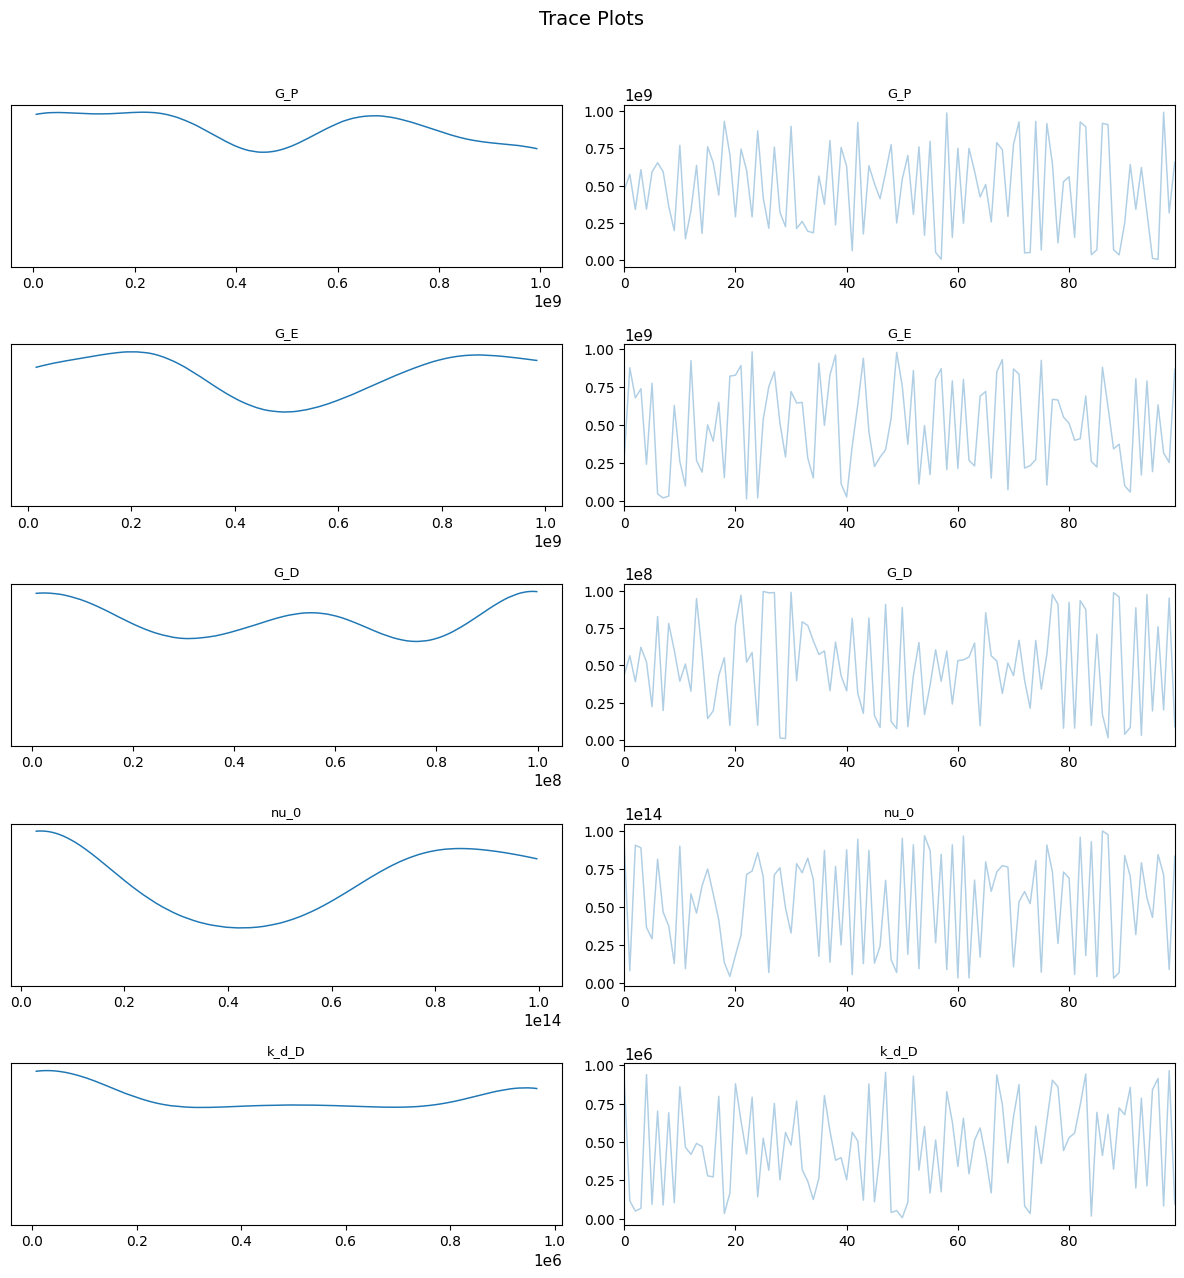

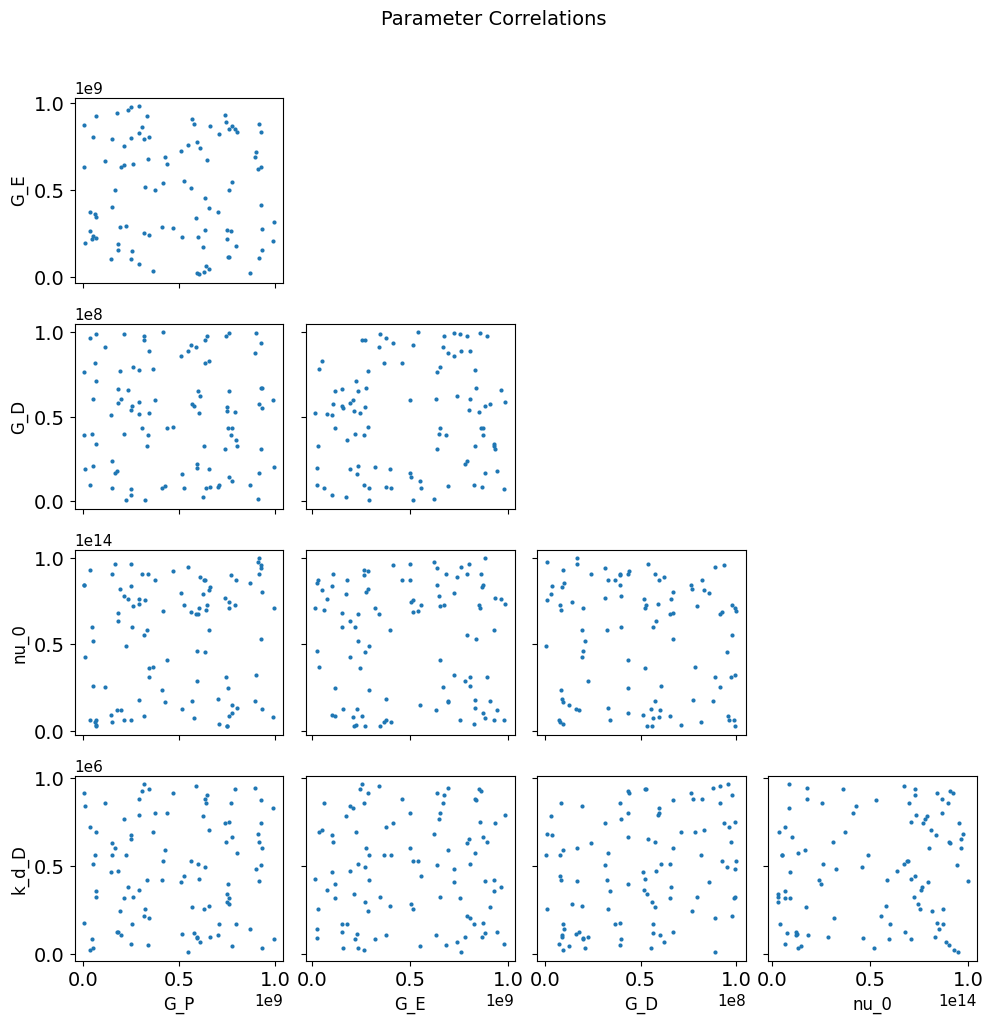

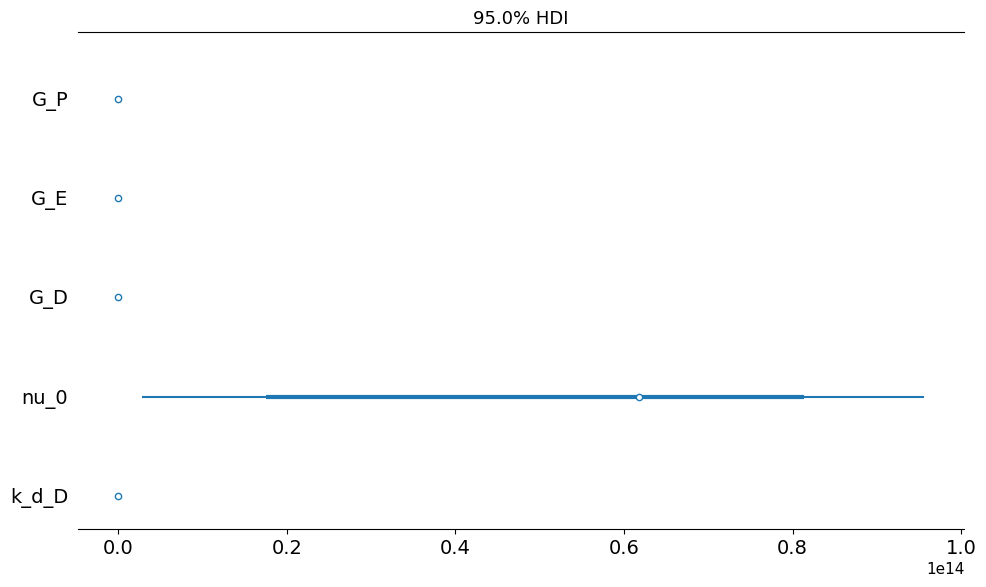

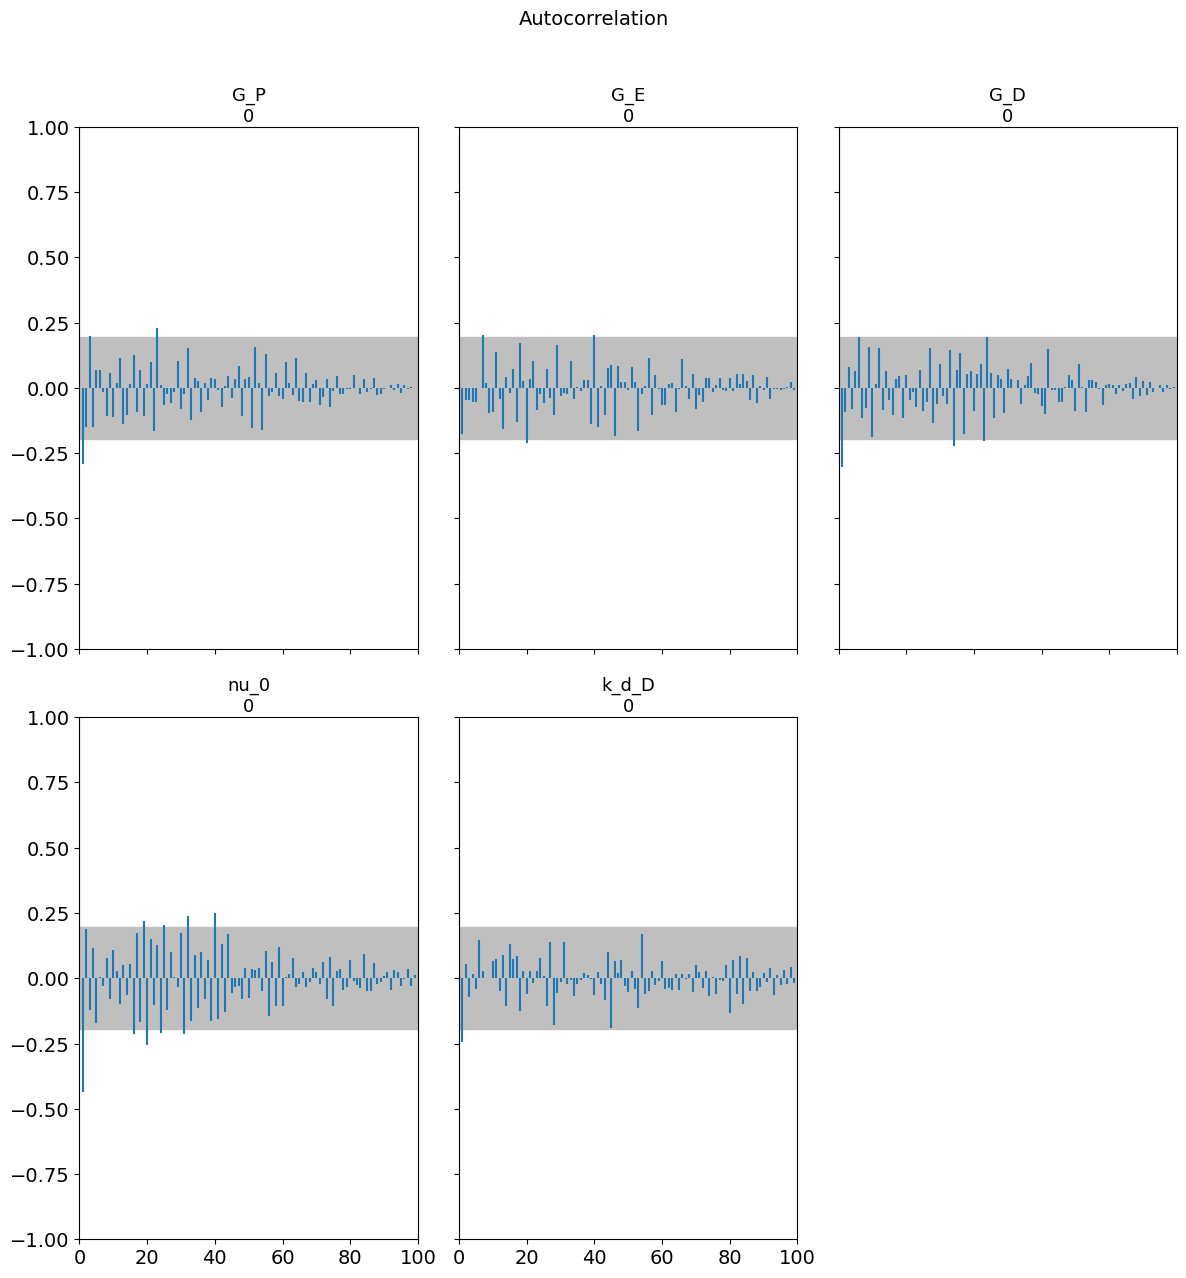

In [8]:
display_arviz_diagnostics(result, fit_params, fast_mode=get_fast_mode())

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_02_creep_ppc.png


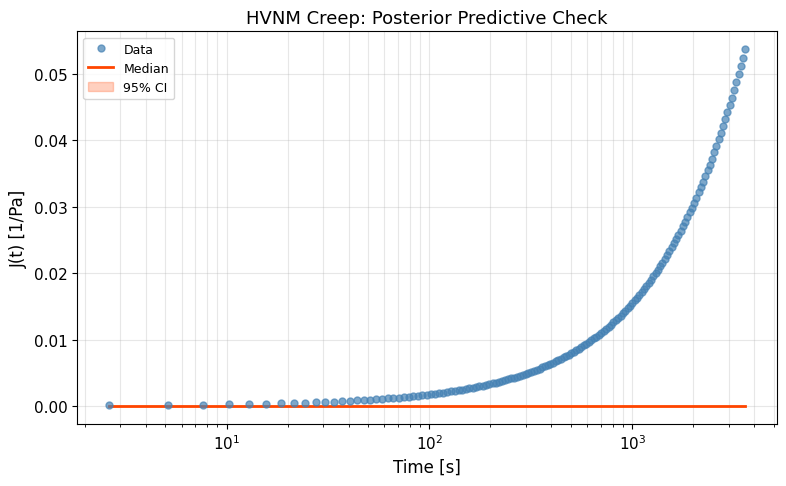

In [9]:
fig = plot_ppc(
    data, model, result.posterior_samples, fit_params,
    title="HVNM Creep: Posterior Predictive Check",
)
save_figure(fig, "hvnm_02_creep_ppc.png")
plt.show()

## 6. Save Results

In [10]:
save_results(
    get_output_dir("creep"), model, result,
    param_names=fit_params,
    extra_meta={"dataset": "PS_190C", "protocol": "creep"},
)

Saved to /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../outputs/hvnm/creep/


## What to Change for Your Data

1. **sigma_applied**: Set to the actual applied stress in your creep experiment
2. **Temperature**: Update `T` override (in Kelvin) to match your experiment
3. **Early-time cut**: Adjust `early_cut` to exclude inertial ringing artifacts
4. **Nanoparticles**: Set `phi > 0` if your material contains fillers

## Troubleshooting

- **J(t) not converging**: Creep compliance spans many decades. Try `use_log_residuals=True` in `.fit()`
- **Negative J(t) predictions**: Check that G_P is large enough (instantaneous elastic compliance J_0 = 1/(G_P*X))
- **Identifiability**: G_E and nu_0 are correlated (both affect the E-network retardation time). Adding SAOS data resolves this.
- **Viscous flow term**: If J(t) grows linearly at long times, ensure G_D and k_d_D allow for steady flow.